Things that need to be done:
- Seamless transition from Hermitian dilation to solution
- Keep track of the system sizes and number of qubits
- Keep matrix A, do not overwrite
- Extraction of output based on Hermitian dilation
- Initialize the qubits with the initial problem we have
- Swap out Unitary simulator with statevector simulator and check memory requirements and speed

In this script we implement O_A instead of U_A as a unitary to simplify the code
and be consistent with the library that creates the phase angles

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.extensions import UnitaryGate

import numpy as np
from scipy.linalg import fractional_matrix_power
from scipy.io import loadmat

from copy import deepcopy

Need to define a simple linear system,
apply the Hermitian dilation if needed

Assume A is square for simplicity

For unitary block-encoding requirement, ||A||<=1

In [2]:
# problem = 'lower triangular'
# problem = 'lower triangular identities'
# problem = 'diagonal'
problem = 'laplacian'

In [3]:
if 'lower triangular'==problem:
    N = 16
    A = np.eye(N)
    for i in range(N-1):
        A[i+1,i] = -1
    A_orig = deepcopy(A)
    A = A/2
    
    RHS_provided = False

In [4]:
if 'lower triangular identities'==problem:
    N = 4
    I = 4
    A = np.eye(N*I)
    
    for i in range(N-1):
        A[(i+1)*I:(i+2)*I,(i)*I:(i+1)*I] = -np.eye(I)
    A_orig = deepcopy(A)
    A = A/2
    
    RHS_provided = False

In [5]:
if 'diagonal'==problem:
    # # A = np.array([[1, 0, 0],[-1, 1, 0],[0, -1, 1]])/2
    # step = 0.025
    step = 0.05
    x = np.diag(np.concatenate( (np.arange(-1,0,step),np.arange(step,1+step,step)) ) )
    # x = np.diag(np.concatenate( (np.arange(1,0,-step),-np.arange(-step,-1-step,-step)) ) )
    # # x = np.diag(np.arange(step,1+step,step))
    # # x = np.diag([1,0.5])
    # # x = np.diag(np.arange(1,0,-step))

    A = x
    A = np.array(A)
    A_orig = deepcopy(A)
    
    RHS_provided = False




# A = np.eye(8)




In [6]:
# # DON'T FORGET TO NORMALIZE A!!!!
if 'laplacian'==problem:
    problem_number = 2
    size = 4
    iterations = int(np.floor(128/size -1))
    # iterations = 7
    K = np.array( loadmat('N_{}_problem_{}.mat'.format(size,problem_number)) ).item()['A']
    R = np.array( loadmat('N_{}_problem_{}.mat'.format(size,problem_number)) ).item()['R']
    B = np.array( loadmat('N_{}_problem_{}.mat'.format(size,problem_number)) ).item()['B']
    f = np.array( loadmat('N_{}_problem_{}.mat'.format(size,problem_number)) ).item()['f']
    f = f/np.linalg.norm(f)
    print('|R|_2 = {}'.format(np.linalg.norm(R,2)))

    A = np.eye((iterations+1)*size,(iterations+1)*size)
    for block in range(iterations):
        A[(block+1)*size:(block+2)*size,(block)*size:(block+1)*size] = -R
#         A[(block+1)*size:(block+2)*size,(block)*size:(block+1)*size] = -np.eye(size)

    A_orig = deepcopy(A)
    # Normalize the matrix using the upper bound
    A = A/2
    np.linalg.norm(A,2)
    
    RHS_provided = True

|R|_2 = 0.9432401136808549


In [7]:
# A_identities = deepcopy(A)

In [8]:
# spy(A_identities)

In [9]:
A_shape = np.shape(A_orig)

In [10]:
# Hermitian Dilation
# Only if A is not Hermitian
if np.any(A != A.conj().T):
    A = np.block([
        [np.zeros(np.shape(A)),A],
        [A.conj().T,np.zeros(np.shape(A))]
    ])
    HD = True
else:
    HD = False
print(HD)
    

True


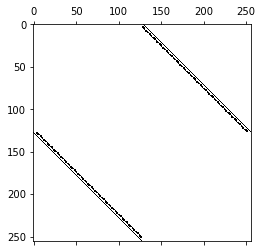

In [11]:
from matplotlib.pyplot import spy
spy(A)

In [12]:
if RHS_provided:
    b = np.zeros(((iterations+1)*size,1))

    for block in range(iterations):
        b[(block+1)*size:(block+2)*size,:] = f
    b = b / np.linalg.norm(b,2)

    b = b.flatten()

    b_orig = deepcopy(b)

    if HD:
        b = np.concatenate([b,np.zeros(b.shape)])
    print(b)

[0.         0.         0.         0.         0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265
 0.08980265 0.08980265 0.08980265 0.08980265 0.08980265 0.0898

In [13]:
# Check the norm and condition number of the matrix
if np.size(A)>1:
    print( '||A||_2 = {} \n cond(A) = {} \n ||A^-1||_2 = {}'.format( np.linalg.norm(A,2), np.linalg.cond(A), np.linalg.norm(np.linalg.inv(A),2) ) )
else:
    print('||A||_2 = {} \n cond(A) = {}'.format(np.linalg.norm(A),1) )

||A||_2 = 0.9704874123654055 
 cond(A) = 21.960544038693037 
 ||A^-1||_2 = 22.628365663360604


The matrix must be padded to a power of 2 to get the appropriate block-encoding in |0^m> 

In [14]:
if np.size(A)>1:
    A_num_qubits = int(np.ceil(np.log2(np.shape(A)[0])))
    padding_size = 2**A_num_qubits - np.shape(A)[0]
    if padding_size > 0:
        A = np.block([
            [A, np.zeros([np.shape(A)[0],padding_size])],
            [np.zeros([padding_size,np.shape(A)[0]]), np.zeros([padding_size,padding_size])]
        ])
else:
    A_num_qubits = 1
    padding_size = 1
    A = np.array([[A,0],[0,0]])
    
print(A_num_qubits)
print(padding_size)


print(A)

8
0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
# If RHS is given, it also needs to be padded
if RHS_provided:
    b = np.pad(b,(0,padding_size))

In [16]:
# Create block encoding of A by creating a Unitary matrix
# Question: does A need to be Hermitian to define this sort of block encoding?
# Answer: Yes, A is defined as Hermitian for QET and QSP
#         But the block encoding U_A does not have to be Hermitian

# This block encoding needs to be the REFLECTION operator in order to
# stay consistent with the conventions of the QET or QSP
# QET uses U_A
# QSP uses O_A

O = np.block([
    [A   ,   -fractional_matrix_power(np.eye(np.shape(A)[0]) - np.linalg.matrix_power(A,2),0.5)],
    [fractional_matrix_power(np.eye(np.shape(A)[0]) - np.linalg.matrix_power(A,2),0.5)   ,   A]
])

print(O)

# We also need to get the block-encoding size, i.e. m, used to encode A in U_A

m = int(np.log2(np.shape(O)[0]) - A_num_qubits)
O_A_num_qubits = int(np.log2(np.shape(O)[0]))

print('m = {} \nNumber of Qubits for O_A is {}'.format(m,O_A_num_qubits))

[[ 0.  0.  0. ... -0. -0. -0.]
 [ 0.  0.  0. ... -0. -0. -0.]
 [ 0.  0.  0. ... -0. -0. -0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
m = 1 
Number of Qubits for O_A is 9


In [17]:
# Check is still Unitary
np.linalg.norm(np.matmul(O,O.T)-np.eye(np.shape(O)[0]),2)

3.231660656321741e-14

Create the unitary gate O_A in Qiskit

In [18]:
blockA = UnitaryGate(O,label='O_A')

Now create the three registers for QSP:
1) a register initialized as 1 for the Z operation a.k.a. |1>
2) a register of size m for the block-encoding, a.k.a. |0^m>
2) a register of size log2(size(O_A))-m that encodes the blocks, a.k.a. |phi>

Note that the first register is an ancilla, which is not needed when m==1 and both complex and real parts of P(A) are needed.
Since we are interested in block encoding of Re(P(A)) this register is needed regardless of m.

We are forming an m+1 block encoding of Re(P(A)) given an m block encoding of A

In [19]:
register_1 = QuantumRegister(size = 1, name = '|0>')
register_2 = QuantumRegister(size = m, name = '|0^m>')
register_3 = QuantumRegister(size = O_A_num_qubits-m, name = '|\phi>')

Now we have the registers set up to begin QSP

What we need now is a function to create the controlled rotations interleaving O_A
The form of the controlled rotations depends on m, the number of blocks used to encode A in O_A

This function will simply return the circuit for rotation given a phase angle

The rotation circuit can be appended to the overall circuit

In [20]:
# Create a rotation circuit in the block-encoding basis

def CR_phi_d(phi, d, register_1, register_2):
    circuit = QuantumCircuit(register_1,register_2,name = 'CR_( \phi \tilde {})'.format(d))
    
    circuit.cnot(register_2,register_1,ctrl_state=0)
    circuit.rz(phi*2, register_1)
    circuit.cnot(register_2,register_1,ctrl_state=0)
    
    return circuit
    

In [21]:
from scipy.io import loadmat
phi_angles = np.array( loadmat('phi_k_50_14.mat') ).item()['phi']

phi_tilde_angles = np.zeros(np.shape(phi_angles))
temp = np.zeros(np.shape(phi_angles))

# plot QSP angles
for d,phi in enumerate(phi_angles):
    if d==0 or d==np.size(phi_angles)-1:
        temp[d] = phi_angles[d] - np.pi/4
    else:
        temp[d] = phi_angles[d]

phase_angles = phi_angles.reshape(phi_angles.shape[0])


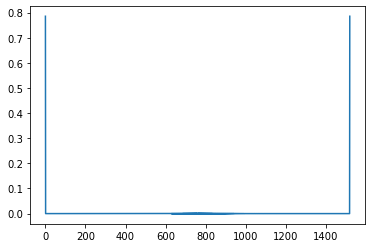

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(phase_angles)

# It seems like using the QSP angles might be more stable numerically....

In [23]:
circuit = QuantumCircuit(register_1, register_2, register_3, name = 'QSP')

if RHS_provided:
    circuit.initialize(b,list(reversed(register_3)))

In [24]:
# First thing is to  Hadamard the ancilla qubit since we want Re(P(A))
circuit.h(register_1)

# Note: QSPPACK produces symmetric phase angles, so reversing phase angles is unnecessary
# for d, phi in enumerate(reversed(phase_angles)):
for d, phi in reversed(list(enumerate(phase_angles))):
    circuit = circuit.compose(CR_phi_d(phi,d,register_1,register_2))
    if d>0:
        # The endianness of the bits matters. Need to change the order of the bits
        circuit.append(blockA,list(reversed(register_3[:])) + register_2[:])


# Apply the final Hadamard gate
circuit.h(register_1)


circuit = circuit.reverse_bits()
circuit.size()

6082

In [25]:
# print(circuit)

In [26]:
# from qiskit import transpile
# circuit = transpile(circuit)

In [27]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer

Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [28]:
# solver = 'unitary'
solver = 'statevector'

machine = "CPU"
# machine = "GPU"

# precision = "single"
precision = "double"

In [29]:
if solver=='unitary':
#     backend = Aer.get_backend('unitary_simulator',precision = 'double',device="GPU")
    backend = Aer.get_backend('unitary_simulator',precision = precision,device=machine)

    job = execute(circuit, backend, shots=0)
    result = job.result()

    QSP_unitary = result.get_unitary(circuit,100)
    QSP_matrix = np.array(QSP_unitary.to_matrix())
    print(QSP_matrix)

elif solver=='statevector':
    backend = Aer.get_backend('statevector_simulator',precision = precision,device=machine)
#     backend = Aer.get_backend('statevector_simulator',precision = 'double',device="GPU")

    job = execute(circuit, backend, shots=0)
    result = job.result()

    QSP_statevector = result.get_statevector()

    print(QSP_statevector)

Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [30]:
if solver=='statevector':
    # We can ignore the padding size and directly use the size of b (considering Hermitian dilation)
    if HD:
        P_A_b = np.real(QSP_statevector.data[int(b_orig.shape[0]):(2*b_orig.shape[0])])
    else:
        P_A_b = np.real(QSP_statevector.data[0:b.shape[0]])
    P_A_b = P_A_b/np.linalg.norm(P_A_b)

In [31]:
b_orig.shape[0]

128

In [32]:
if solver=='statevector':
    print(P_A_b)

[-3.82354272e-12 -6.65299431e-12 -8.44635464e-12 -8.89789508e-12
  9.01703642e-03  9.01703642e-03  9.01703641e-03  9.01703641e-03
  1.37907616e-02  1.80340728e-02  1.80340728e-02  1.80340728e-02
  1.83148802e-02  2.50542569e-02  2.70511093e-02  2.70511093e-02
  2.18846209e-02  3.18395172e-02  3.51284505e-02  3.60681457e-02
  2.52876693e-02  3.77196298e-02  4.30399631e-02  4.46429726e-02
  2.82549604e-02  4.33900181e-02  5.03076707e-02  5.29056516e-02
  3.10979250e-02  4.85400404e-02  5.72919205e-02  6.07001088e-02
  3.36886981e-02  5.34675543e-02  6.37942784e-02  6.81132919e-02
  3.61599266e-02  5.80365286e-02  6.99841569e-02  7.50978514e-02
  3.84553985e-02  6.23811068e-02  7.57852245e-02  8.17084433e-02
  4.06349337e-02  6.64468065e-02  8.12818379e-02  8.79380826e-02
  4.26764120e-02  7.02982705e-02  8.64500335e-02  9.38227686e-02
  4.46089527e-02  7.39176150e-02  9.13357627e-02  9.93702827e-02
  4.64258525e-02  7.73391151e-02  9.59369743e-02  1.04606369e-01
  4.81428466e-02  8.05606

In [33]:
if solver=='statevector':
    expected_P_A_b = np.linalg.solve(A_orig,b_orig)
    expected_P_A_b = expected_P_A_b/np.linalg.norm(expected_P_A_b)

In [34]:
if solver=='statevector':
    print(expected_P_A_b)

[0.         0.         0.         0.         0.00901704 0.00901704
 0.00901704 0.00901704 0.01379076 0.01803407 0.01803407 0.01803407
 0.01831488 0.02505426 0.02705111 0.02705111 0.02188462 0.03183952
 0.03512845 0.03606815 0.02528767 0.03771963 0.04303996 0.04464297
 0.02825496 0.04339002 0.05030767 0.05290565 0.03109792 0.04854004
 0.05729192 0.06070011 0.0336887  0.05346755 0.06379428 0.06811329
 0.03615993 0.05803653 0.06998416 0.07509785 0.0384554  0.06238111
 0.07578522 0.08170844 0.04063493 0.06644681 0.08128184 0.08793808
 0.04267641 0.07029827 0.08645003 0.09382277 0.04460895 0.07391761
 0.09133576 0.09937028 0.04642585 0.07733912 0.09593697 0.10460637
 0.04814285 0.08056067 0.10028179 0.10954369 0.04975987 0.08360279
 0.10437684 0.11420219 0.05128658 0.08646977 0.10824154 0.11859553
 0.05272555 0.08917555 0.1118855  0.1227401  0.0540835  0.09172668
 0.11532355 0.12664909 0.05536392 0.09413369 0.11856585 0.13033646
 0.05657194 0.09640361 0.12162451 0.13381438 0.0577112  0.0985

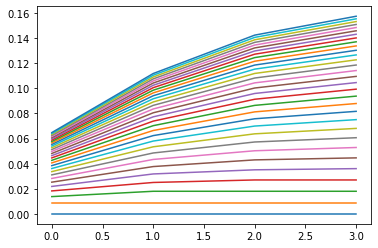

In [35]:
if solver=='statevector':
    for iteration_number in range(iterations):
        plt.plot(expected_P_A_b[iteration_number*size:(iteration_number+1)*size])
        

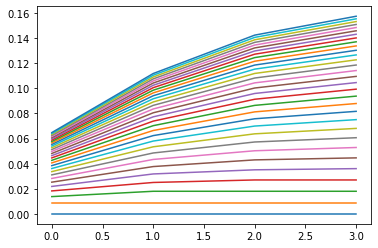

In [36]:
if solver=='statevector':
    for iteration_number in range(iterations):
        plt.plot(P_A_b[iteration_number*size:(iteration_number+1)*size])


Make error convergence plots

In [37]:
exact_solution = np.linalg.solve(K,f)

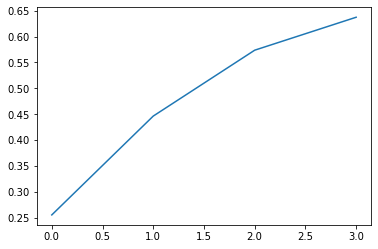

In [38]:
plt.plot(exact_solution/np.linalg.norm(exact_solution))

In [39]:
x_exact_normalized = exact_solution
x_exact_normalized = x_exact_normalized/np.linalg.norm(x_exact_normalized)

Text(0.5, 1.0, 'N = 4, 31 iterations')

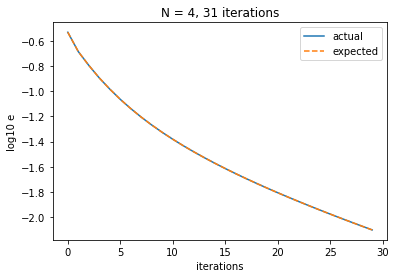

In [40]:
error_actual = []
if solver=='statevector':
    for iteration_number in range(1,iterations):
        e = x_exact_normalized - (P_A_b[iteration_number*size:(iteration_number+1)*size]/np.linalg.norm(P_A_b[iteration_number*size:(iteration_number+1)*size])).reshape(np.shape(x_exact_normalized))
        error_actual.append(np.linalg.norm(e))
plt.plot(np.log10(error_actual))


error_expected = []
if solver=='statevector':
    for iteration_number in range(1,iterations):
        e = x_exact_normalized - (expected_P_A_b[iteration_number*size:(iteration_number+1)*size]/np.linalg.norm(expected_P_A_b[iteration_number*size:(iteration_number+1)*size])).reshape(np.shape(x_exact_normalized))
        error_expected.append(np.linalg.norm(e))
plt.plot(np.log10(error_expected),'--')


plt.legend(['actual','expected'])

plt.xlabel('iterations')
plt.ylabel('log10 e')
plt.title('N = {}, {} iterations'.format(size,iterations))

In [41]:
error_actual

[0.2954147272768631,
 0.20716126249741215,
 0.1610738374085094,
 0.12783232395252256,
 0.10421134632012032,
 0.08635817568595656,
 0.0728740188245846,
 0.062286482603507366,
 0.05392095399796013,
 0.04712729818452869,
 0.04156352958071551,
 0.036916999256223285,
 0.0330040328724857,
 0.02966237384505052,
 0.02678738705678047,
 0.024288675881079896,
 0.022103275065270954,
 0.020177483075122928,
 0.018471524151127766,
 0.01695165466652804,
 0.01559166715685967,
 0.014369321511470289,
 0.013266712936887535,
 0.01226858415443813,
 0.011362315101790296,
 0.010537082719389444,
 0.009783748805472232,
 0.009094417311277761,
 0.008462314522463831,
 0.007881541499251871]

In [42]:
error_expected

[0.29541472679943553,
 0.2071612622097456,
 0.1610738371885323,
 0.12783232378687706,
 0.10421134619606436,
 0.08635817558623228,
 0.07287401873059902,
 0.06228648250937697,
 0.05392095391114429,
 0.04712729809718008,
 0.04156352949844959,
 0.03691699917231572,
 0.033004032780714,
 0.02966237375315715,
 0.02678738696428315,
 0.024288675790103742,
 0.022103274980925573,
 0.020177483002222843,
 0.01847152408491064,
 0.016951654605781453,
 0.015591667105392957,
 0.01436932146593965,
 0.013266712899399713,
 0.012268584120815574,
 0.011362315071776855,
 0.010537082695908606,
 0.00978374878633063,
 0.009094417294446547,
 0.008462314504168221,
 0.007881541478750568]

In [43]:
np.linalg.cond(A_orig)

21.96054403869294

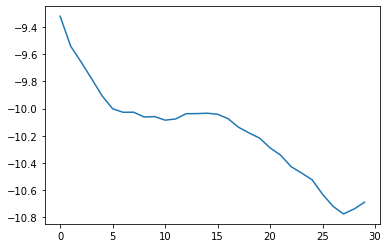

In [44]:
plt.plot(np.log10(np.abs(np.array(error_actual)-error_expected)))

Get L2 error if unitary solver was used

In [45]:
if solver=='unitary':
    
    A_inv = np.linalg.inv(A_orig)

    if HD:
        # Extract the appropriate block
        N1 = 2**int(O_A_num_qubits-2)
        # Remove the padding
        N2 = np.shape(A_orig)[0]
        P_A = np.real(QSP_matrix[N1:(N1+N2),0:N2])
    else:
        # Extract the appropriate block
        # Remove the padding
        N2 = np.shape(A_orig)[0]
        P_A = np.real(QSP_matrix[0:N2,0:N2])


    print(P_A/P_A[0,0])

    print("Error: {}".format(np.linalg.norm(P_A/abs(P_A[0,0])-A_inv,2)))

In [46]:
if 'unitary'==solver and 'diagonal'==problem:
    plt.plot(np.arange(-1,0,0.05),np.diag(P_A)[0:20]/abs(P_A[0,0]),'r',linewidth=3)
    plt.plot(np.arange(0.05,1.05,0.05),np.diag(P_A)[20:40]/abs(P_A[0,0]),'r',linewidth=3)
    plt.plot(np.arange(-1.25,0,0.01),1/np.arange(-1.25,0,0.01),'k--',)
    plt.plot(np.arange(0.01,1.25,0.01),1/np.arange(0.01,1.25,0.01),'k--')

    plt.ylim([-25,25])

Plot error for eigenvalues if diagonal matrix is solved

In [47]:
if 'unitary'==solver and 'diagonal'==problem:
    error = np.abs(np.diag(A_inv)-np.diag(P_A / abs(P_A[0,0])))
    plt.plot(np.diag(A)[0:int(len(error)/2)],error[0:int(len(error)/2)],np.diag(A)[int(len(error)/2):len(error)],error[int(len(error)/2):len(error)])
    plt.xlabel('normalized eigenvalues')
    plt.ylabel('error')
    
#     # np.set_printoptions(threshold=np.inf)
#     for i in range(P_A.shape[0]):
#     #     print(QSP_matrix[i,i]/0.0062)
#         print(P_A[i,i]/abs(P_A[0,0]))
#     # print(QSP_matrix/QSP_matrix[0,0])


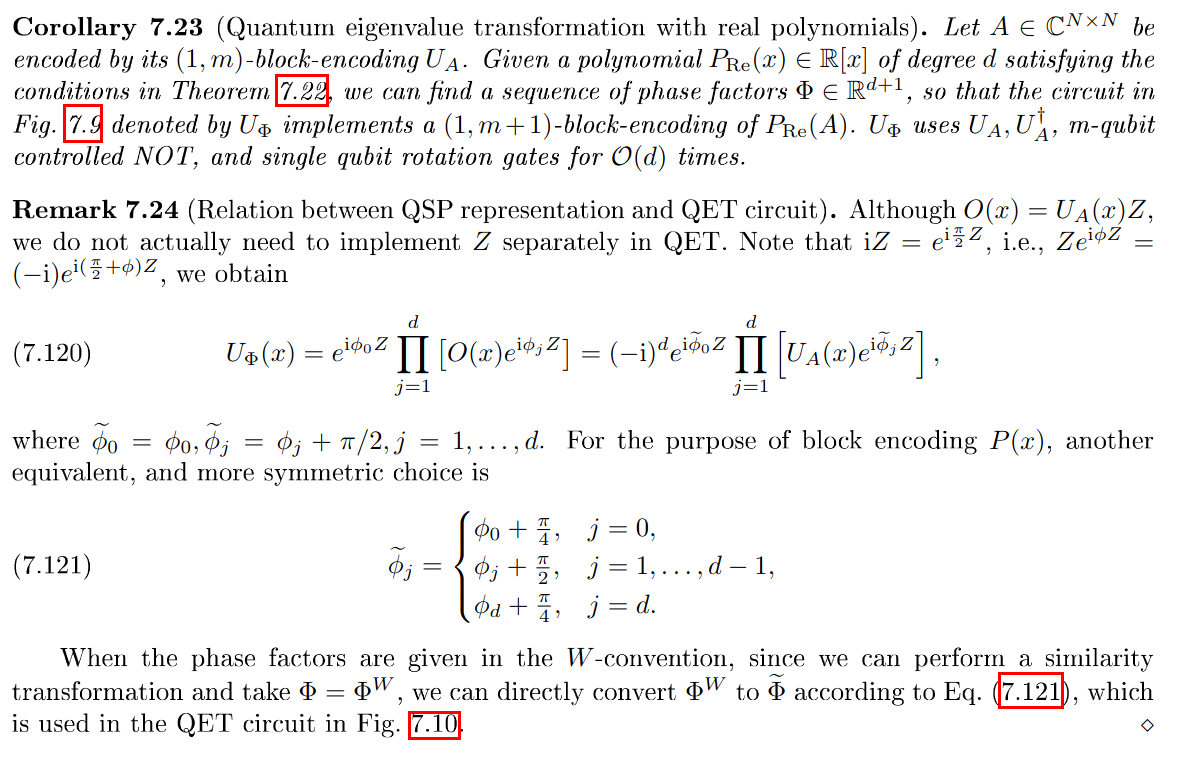

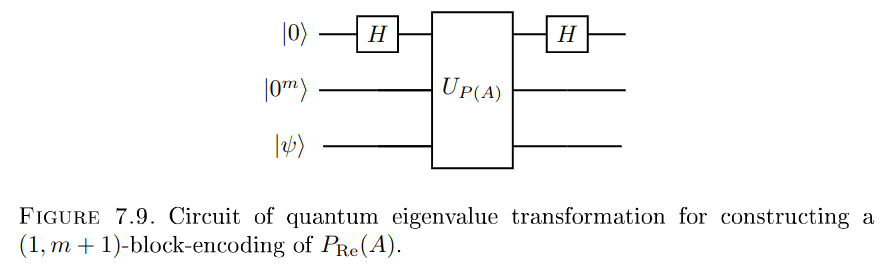

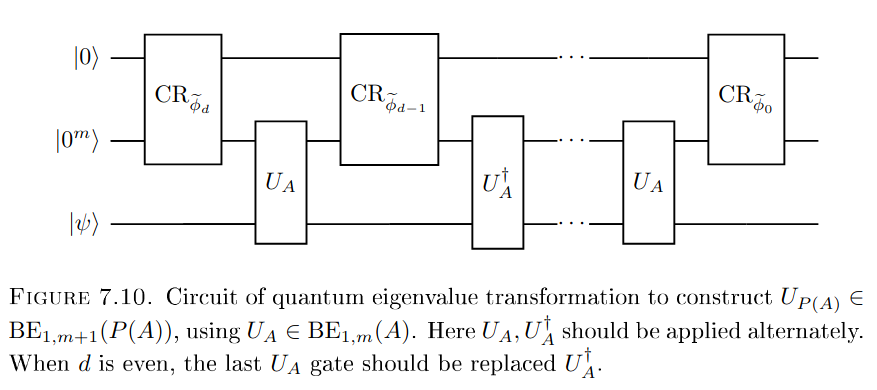

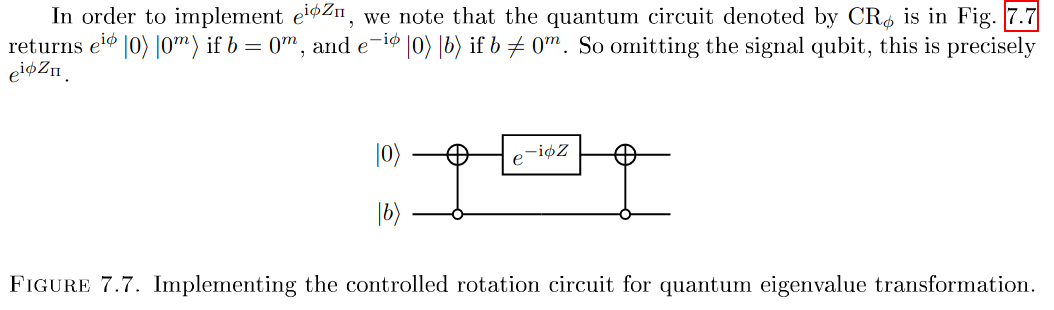